# 폐렴 진단기

## 1. 데이터 확인 및 하이퍼 파라미터 정하기

In [1]:
import re 
import os 
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
BATCH_SIZE = 32
IMAGE_SIZE = [240, 240]
EPOCHS = 20

## 2. train 데이터와 validation 데이터 나누기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [5]:
count_normal = len([filename for filename in train_filenames if 'NORMAL' in filename])
count_pneumonia = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print('Count_normal : {}'.format(count_normal))
print('Count_pneumonia : {}'.format(count_pneumonia))

Count_normal : 1094
Count_pneumonia : 3091


## 3. 데이터 전처리

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
train_img_count = tf.data.experimental.cardinality(train_list_ds).numpy()
print('train_img_count : {}'.format(str(train_img_count)))
val_img_count = tf.data.experimental.cardinality(val_list_ds).numpy()
print('val_img_count : {}'.format(str(val_img_count)))

train_img_count : 4185
val_img_count : 1047


In [8]:
class_names = np.array([str(tf.strings.split(item, os.path.sep[-1].numpy())[2:-1]
                           for item in tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*')))])
print(class_names)

['<generator object <genexpr> at 0x7f7c9f507f50>']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'

In [36]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (240, 240, 3)
Label:  True


In [37]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 4. 전처리 데이터 시각화하기

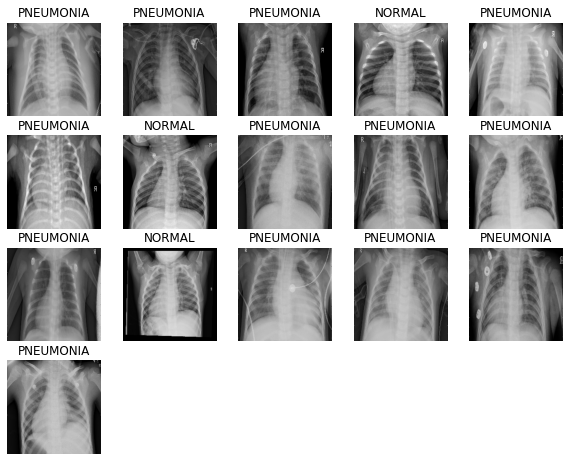

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## 5. 모델 설계하기

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
## weight 불균형 맞춰주기
weight_for_0 = (1 / count_normal)*(train_img_count)/2.0 
weight_for_1 = (1 / count_pneumonia)*(train_img_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.91
Weight for class 1: 0.68


In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 240, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 60, 60, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 30, 30, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 15, 15, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 128)      

## 6. 모델 훈련하기

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=train_img_count // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=val_img_count // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/20
130/130 [==============================] - 31s 240ms/step - loss: 0.3798 - accuracy: 0.8000 - precision: 0.9652 - recall: 0.7569 - val_loss: 0.5570 - val_accuracy: 0.7549 - val_precision: 0.7549 - val_recall: 1.0000
Epoch 2/20
130/130 [==============================] - 24s 184ms/step - loss: 0.1981 - accuracy: 0.9219 - precision: 0.9764 - recall: 0.9162 - val_loss: 0.7321 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 3/20
130/130 [==============================] - 27s 210ms/step - loss: 0.1631 - accuracy: 0.9380 - precision: 0.9792 - recall: 0.9358 - val_loss: 0.9906 - val_accuracy: 0.7549 - val_precision: 0.7549 - val_recall: 1.0000
Epoch 4/20
130/130 [==============================] - 30s 232ms/step - loss: 0.1456 - accuracy: 0.9459 - precision: 0.9811 - recall: 0.9451 - val_loss: 1.3750 - val_accuracy: 0.7539 - val_precision: 0.7539 - val_recall: 1.0000
Epoch 5/20
130/130 [==============================] - 27s 210ms/step - loss: 0.1446 - accura

## 7. 모델 훈련 시각화하기

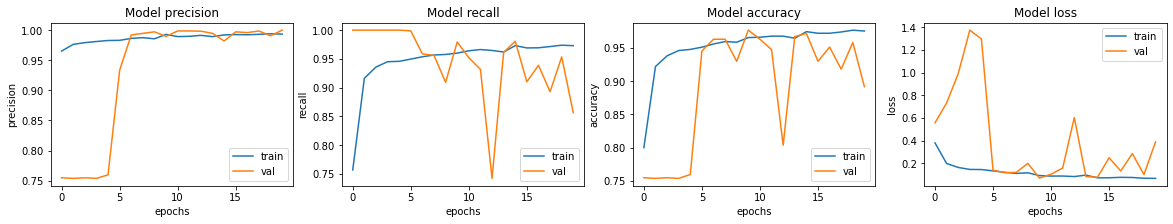

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## 8. 모델 평가하기

In [24]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 20s 1s/step - loss: 0.4467 - accuracy: 0.8766 - precision: 0.8808 - recall: 0.9282


## 9. 모델 저장하기

In [25]:
from tensorflow.keras.models import load_model
path = os.getenv('HOME') + '/aiffel/chest_xray/weight/size_reverse_weight.h5'
model.save(path)

## 10. 모델 비교하기

vanila_weight : BATCH_SIZE = 16, IMAGE_SIZE = [180, 180], EPOCHS = 20, 좌우반전 X     
left_and_right_reverse_weight : vanila_weight, 좌우반전 O     
dropout_weight : vanila + convolution_layer에서 dropout(0.3)으로 조절 + FC layer에서 첫번째 dropout비율 0.7에서 0.4로 조절    
size_weight : BATCH_SIZE = 32, IMAGE_SIZE = [240, 240], EPOCHS = 20, 좌우반전 X     
imbalance_weight : vanila - class_weight     
size_reverse_weight : 좌우반전 O + size_weight

In [39]:
weight_path = os.getenv('HOME') + '/aiffel/chest_xray/weight/size_reverse_weight.h5'
model = load_model(weight_path)
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 2s 108ms/step - loss: 0.4467 - accuracy: 0.8766 - precision: 0.8808 - recall: 0.9282


In [27]:
weight_path = os.getenv('HOME') + '/aiffel/chest_xray/weight/size_weight.h5'
model = load_model(weight_path)

In [28]:
loss, acc, prec, rec = model.evaluate(test_ds)

20/20 [==============================] - 2s 107ms/step - loss: 0.4803 - accuracy: 0.8782 - precision: 0.8985 - recall: 0.9077


-----

In [41]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [42]:
BATCH_SIZE = 16
IMAGE_SIZE = [180,180]
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [31]:
weight_path = os.getenv('HOME') + '/aiffel/chest_xray/weight/vanila_weight.h5'
model = load_model(weight_path)
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 52ms/step - loss: 0.4364 - accuracy: 0.8670 - precision: 0.8886 - recall: 0.9000


In [32]:
weight_path = os.getenv('HOME') + '/aiffel/chest_xray/weight/dropout_weight.h5'
model = load_model(weight_path)
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 54ms/step - loss: 0.6271 - accuracy: 0.8478 - precision: 0.8172 - recall: 0.9744


In [33]:
weight_path = os.getenv('HOME') + '/aiffel/chest_xray/weight/left_and_right_reverse_weight.h5'
model = load_model(weight_path)
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 1.1917 - accuracy: 0.7436 - precision: 0.7091 - recall: 1.0000


In [43]:
weight_path = os.getenv('HOME') + '/aiffel/chest_xray/weight/imbalance_weight.h5'
model = load_model(weight_path)
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 55ms/step - loss: 0.9299 - accuracy: 0.7804 - precision: 0.7419 - recall: 0.9949


## 11. 모델 비교하기

recall 점수로써 제일 좋은 모델은 기본 weight에 좌우반전을 시킨 left_and_right_reverse_weight였다.    
그러나 해당 모델은 낮은 accuracy와 precision으로 평가할때 효과가 떨어지는 모델이라는 것을 알 수 있다.    
balance를 고려하지 않은 모델 또한 recall점수는 매우높지만 accuracy 점수가 낮아 실제 효용가치가 없을 가능성이 높다.    
dropout만 수정한 모델같은 경우 recall점수가 매우 높아 accuracy점수도 어느정도 괜찮기 때문에 의료쪽에서 유용하게 쓸 수 있는 모델이라는 생각을 했다.    
size를 단순하게 키운 size_weight모델들은 size가 비교적 작은 모델과 비교했을때 정확도 측면에서 높다고 볼 수 있다.    

## 12. 배운 점

오늘 노드하면서 배운 점은 처음으로 model을 저장하는 방식을 차용하는데에 있다고 생각한다.    
기존 노드를 할때 나는 조금씩 수정하면서 전체 파일을 지속적으로 복붙했다.    
이번 노드같은 경우 model의 weight를 저장해 사용함으로써 더 효율적인 실험이 되었다고 생각한다.    
